### Drone Dataset Demo

This tutorial demonstrates how to parse the information from the drone dataset.

In [9]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import shapely
import os
import mediapy

Data are stored with filenames starting with its videoId in .csv files. To load, we can utilize the landmarks data which containt frame information.

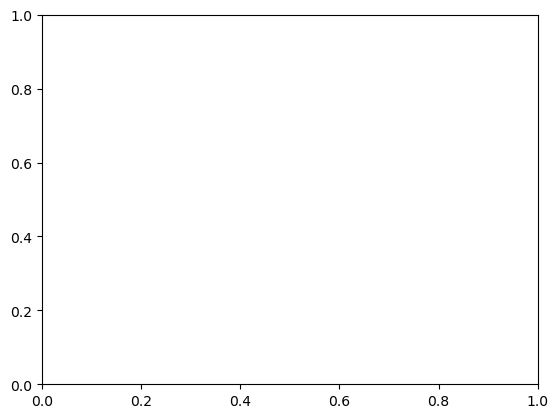

In [13]:
# Inits
raw_data_dir = Path('dataset/drone_dataset/Drone_data_raw/raw')

tot_stat = []
imgs = []
unit = 'meters' # pixel or meters

fig, ax = plt.subplots(1, 1)
plt.axis('equal')

# Load data
scene_landmark = raw_data_dir / 'landmark' / '5002_landmarks.csv'
# scene_list = raw_data_dir.glob('landmark/*.csv')

scene_id = scene_landmark.name.split('_')[0]

landmarks = pd.read_csv(scene_landmark)
frame_list = landmarks['frame'].dropna().to_list()

tracks = pd.read_csv(raw_data_dir / f'tracks/{scene_id}_tracks.csv')
tracks_meta = pd.read_csv(raw_data_dir / f'tracksMeta/{scene_id}_trackMeta.csv')
tot_stat.append(tracks_meta['class'].value_counts())

fname = [f for f in os.listdir(raw_data_dir / 'mapSegmentation/') if scene_id in f][0]
map_seg = pd.read_csv(raw_data_dir / f'mapSegmentation/{fname}')

ped_ids = tracks_meta.loc[tracks_meta['class'] == 'pedestrian']
parked_car_ids = tracks_meta.loc[tracks_meta['class'] == 'parked car']
car_ids = tracks_meta.loc[tracks_meta['class'] == 'car']
bicycle_ids = tracks_meta.loc[tracks_meta['class'] == 'bicycle']

recording_meta = pd.read_csv(raw_data_dir / f'recordingMeta/{scene_id}_recordingMeta.csv')
px2meter = recording_meta['px2meter'][0]

if unit == 'pixel':
    scale = px2meter
elif unit == 'meters':
    scale = 1.0

We can then visualize the data from the parsed information. Map information is stored as vertices of the lane segment polygons in *pixel* units with the y-value inverted.

In [11]:
# Draw lane segments
map_renders = []
for col_index in np.arange(0, len(map_seg.columns), 2):
    segment_type = map_seg.columns[col_index].split('_')[0]
    x_col = map_seg.iloc[:, col_index].dropna().to_numpy() # pixel
    y_col = map_seg.iloc[:, col_index+1].dropna().to_numpy() # pixel
    map_renders.append(ax.fill(x_col*px2meter/scale, -y_col*px2meter/scale, 
                               color='magenta' if segment_type == 'intersection' else 'grey', alpha=0.5))

For tracked objects, position information are stored in *meters*. Car objects contain bounding box information while pedestrian and bicycle classes does not have any.

In [12]:
def bounding_box(x_center, y_center, heading_deg, length, width, scale):
    heading_rad = np.pi * heading_deg / 180
    length_cos = 0.5 * length * np.cos(heading_rad)
    length_sin = 0.5 * length * np.sin(heading_rad)
    width_cos = 0.5 * width * np.cos(heading_rad)
    width_sin = 0.5 * width * np.sin(heading_rad)
 
    pos1 = np.array([x_center - length_cos - width_sin, y_center - length_sin + width_cos]) / scale
    pos2 = np.array([x_center - length_cos + width_sin, y_center - length_sin - width_cos]) / scale
    pos3 = np.array([x_center + length_cos + width_sin, y_center + length_sin - width_cos]) / scale
    pos4 = np.array([x_center + length_cos - width_sin, y_center + length_sin + width_cos]) / scale

    return shapely.Polygon((pos1, pos2, pos3, pos4))

# Draw tracked objects
for frame in frame_list:
    frame_idx = int(frame.split('_')[1])

    rows_in_frame = tracks.loc[tracks['frame'] == frame_idx]

    peds_in_frame = rows_in_frame[rows_in_frame['trackId'].isin(ped_ids['trackId'])]
    parked_cars_in_frame = rows_in_frame[rows_in_frame['trackId'].isin(parked_car_ids['trackId'])]
    cars_in_frame = rows_in_frame[rows_in_frame['trackId'].isin(car_ids['trackId'])]
    bicycles_in_frame = rows_in_frame[rows_in_frame['trackId'].isin(bicycle_ids['trackId'])]

    # bicycle and pedestrians
    ped_x, ped_y = peds_in_frame['xCenter'].to_numpy()/scale, peds_in_frame['yCenter'].to_numpy()/scale
    bic_x, bic_y = bicycles_in_frame['xCenter'].to_numpy()/scale, bicycles_in_frame['yCenter'].to_numpy()/scale

    ped_render = ax.scatter(ped_x, ped_y, color='green')
    bic_render = ax.scatter(bic_x, bic_y, color='orange')
    
    # cars
    cars_render = []
    for idx, car in cars_in_frame.iterrows():
        heading_deg = car['heading'] # degree
        x_pos = car['xCenter'] # meters
        y_pos = car['yCenter'] # meters

        length = car['length'] # meters
        width = car['width'] # meters

        car_bb = bounding_box(x_pos, y_pos, heading_deg, length, width, scale)
        cars_render.append(ax.fill(*car_bb.exterior.xy, color='blue', alpha=0.2))

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    imgs.append(image_from_plot)
    ped_render.remove()
    bic_render.remove()
    for car in cars_render:
        for c in car:
            c.remove()

mediapy.show_video(imgs, fps=10)
tot_stat = pd.concat(tot_stat, axis=1).fillna(value=0)

/tmp/ipykernel_343003/4030065189.py:33: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
